# 7 - Question answering

There are many flavours of question answering (QA), but the most common is extractive QA, which involves questions whose answer can be identified as a psan of text in a document, where the document might be a web page, legal contract, or news article. The two-stage process of first retrieving relevant documents and then extracting answers from them is also the basis for many modern QA systems, including:

* semantic search engines
* intelligent assistants
* automated information extractors

In this chapter, we'll apply this process to tackle a common problem facing ecommerce websites: helping consumers answer specific queries to evaluate a product. We'll see that customer reviews can be used as a rich and challenging source of information for QA, and along the way we'll learn how transformers act as a powerful *reading comprehension* models that can extract meaning from text. 

----

**Note:** This chapter focuses on <span style="color:blue"><b>extractive QA</b></span>, but other forms of QA may be more suitable for your use case. For example, <span style="color:blue">community QA</span> involves gathering question-answer pairs that are generated by users on forums like Stack Overflow, and then using semantic similarity search to find the closest matching answer to a new question. There is also <span style="color:blue">long-form QA</span>, which aims to generate complex paragraph-length answers to open-ended questions like "Why is the sky blue?" Remarkably, it is also possible to do QA over tables, and transformer models like TAPAS can even perform aggregations to produce the final answer!

----



## 7.1 - Building a review-based QA system

If you have ever purchased a product online, you probably relied on customer reviews to help inform your decision. These reviews can often help answer specific questions like "Does this guitar come with a strap?" or "Can I use this camera at night?" that may be hard to answer from the product description alone. However, popular products can have hundreds to thousands of reviews, so it can be a major drag to find one that is relevant. One alternative is to post your question on the community QA platform provided by websites like Amazon, but it usually takes days to get an answer (if you get one at all). Wouldn't it be nice if we could get an immediate answer like Google sometimes provides with its search engine?

<img src="images/google_search_qa.PNG" title="" alt="" width="700" data-align="center">


### 7.1.1 - The dataset

To build our QA system we'll use the [SubjQA dataset](https://arxiv.org/abs/2004.14283), which consists of more than 10000 customer reviews in English about products and services in six domains: Trip-Advisor, Restaurants, Movies, Books, Electronics, and Grocery. As illustrated in the following figure, each review is associated with a question that can be answered using one or more sentences from the review.

<img src="images/qa_product_example.PNG" title="" alt="" width="600" data-align="center">

the interesting aspect of this dataset is that most of the questions ansd answers are *subjective*; that is, they depend on the personal experience of the users. This example shows why this feature makes the task potentially more difficult than finding answers to factual questions like "What is the currency of the United Kingdom?" First, the query is about "poor quality", which is subjective and depends on the user's definition of quality. Second, important parts of the query do not appear in the review at all, which means it cannot be answered with shortcuts like keyword search or paraphrasing the input question. These features make SubjQA a realistic dataset to benchmark our review-based QA models on, since user-generated content like that resembles what we might encounter in the wild.

----

**Note:** QA systems are usually categorized by the domain of data that they have access to when responding to a query. *Closed-domain QA* deals with questions about a narrow topic (e.g., a single product category), while *open-domain QA* deals with questions about almost anything (e.g., Amazon's whole product catalog). In general, closed-domain QA involves searching through fewer documents than the open-domain case.

----

Let's begin by downloading the dataset from the Hugging Face Hub. We can use the `get_dataset_config_names()` function to find out which subsets are available:

In [6]:
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

For our use case, we'll focus on building a QA system for the Electronics domain. To download the `electronics` subset, we just need to pass this value to the `name` argument of the `load_dataset()` function:

In [8]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Like other question answering datasets on the Hub, SubjQA stores the answers to each question as a nested dictionary. For example, if we inspect one of the rows in the `answers` column:

In [9]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


we can see that the answers are stored in a `text` field, while the starting character indices are provided in `answer_start`. To explore tehe dataset more easily, we'll flatten these nested column with the `flatten()` method and convert each split to a Pandas `DataFrame` as follows:

In [10]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Notice that the dataset is relatively small, with only 1908 examples in total. This simulates a real-world scenario, since getting domain experts to label extractive QA datasets is labor-intensive and expensive. For example, the CUAD dataset for extractive QA on legal contracts is estmated to have a value of 2$ million to account for the legal expertise needed to annotate its 13000 examples! (see [Hedrycks et al., 2021](https://arxiv.org/abs/2103.06268))

There are quite a few columns in the SubjQA dataset, but the most interesting ones for building our QA system are shown in the following table:

<img src="images/subjqa_data.PNG" title="" alt="" width="600" data-align="center">


Let's focus on these columns and take a look at a few of the training examples. We can use the `sample()` method to select a random sample:



In [11]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


From these examples we can make a few observations. First, the questions are not gramatically correct, which is quite common in the FAQ sections of ecommerce websites. Second, an empty `answers.text` entry denotes "unanswerable" questions whose answer cannot be found in the review. Finally, we can use the start index and length of the answer span to slice out the text in the review that corresponds to the answer:

In [12]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

Next, let's get a feel for what types of questions are in the training set by counting the questions that begin with a few common starting words:

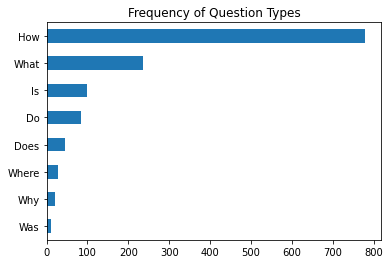

In [14]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()


We can see that questions beginning with "How", "What", and "Is" are the most common ones, so let's have a look at some examples:

In [15]:
for question_type in ["How", "What", "Is"]:
  for question in (
    dfs["train"][dfs["train"].question.str.startswith(question_type)]
    .sample(n=3, random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


-----

**Note:** The (question, review, [answer sentences]) format of SubjQA is commonly used in extractive QA datasets, and was pioneered in the Stanford Question Answering Dataset (SQuAD), which was presented in [Rajpurkar et al (2016)](https://arxiv.org/abs/1606.05250). This is a famous dataset that is often used to test the ability of machines to read a passage of text and answer questions about it. The dataset was created by sampling several hundred English articles from Wikipedia, partitioning each article into paragraphs, and then asking crowdworkers to generate a set of questions and answers for each paragraph. In the first version of SQuAD, each answer to a question was guaranteed to exist in the corresponding passage. Bt it wasn't long before sequence models started performing better than humans at extracting the correct span of text with the answer. To make the task more difficult, SQuAD 2.0 was created by agumenting SQuAD 1.1 with a set of adversarial questions that are relevant to a given passage but cannot be answered from the text alone ([Rajpurkar and Liang, 2018](https://arxiv.org/abs/1806.03822)). The state of the art as of mid 2021 is shown in the following figure, with most models since 2019 surpassing human performance

<img src="images/squad_historical_performance.PNG" title="" alt="" width="500" data-align="center">

However, this superhuman performance does not appear to reflect genuine reading comprehension, since answers to the "unanswerable" questions can usually be identified through patterns in the passages like antonyms. To adress these problems Google released the Natural Questions dataset ([Kwiatkowski, 2019](dx.doi.org/10.1162/tacl_a_00276)), which involves fact-seeking questions obtained from Google search users. The answers in NQ are much longer than in SQuAD and present a more challenging benchmark.

-----

### 7.1.2 - Extracting answers from text

The first thing we'll need for our QA system is to find a way to identify a potential answer as a span of text in a customer review. For example, if we have a question like "Is it waterproof?" and the review passage is "This watch is waterproof at 30m depth", then the model should output "waterproof at 30m". To do this we'll need to understand how to:

* Fram the supervised learning problem
* Tokenize and encode text for QA tasks
* Deal with long passages that exceed a model's maximum context size

#### Span classification

<span style="color:blue">The most common ay to extract answers from text is by framing the problem as a <b>span classification task</b>, where the start and end tokens of an answer span act as the labels that a model needs to predict.</span>

<img src="images/span_classification.PNG" title="" alt="" width="500" data-align="center">

Since our training set is relatively small, with only 1295 examples, a good strategy is to start with a language model that has already been fine-tuned on a large-scale QA dataset like SQuAD. In general, these models have strong reading comprehension capabilities and serve as a good baseline upon which to build a more accurate system.

This is a somewhat different approach to that taken in previous chapters, where we tipically started with a pretrained model and fine-tuned the task-specific head ourselves. For extractive QA, we can actually start with a fine-tuned model since the structure of the labels remains the same across datasets.

There a more than 400 QA models to choose from in the HuggingFace Hub, so which one should we pick? In general, the answer depends on various factors like wether our corpus is mono- or mulitlingual and the constraints of running the model in a production environment. The following table lists a few models that provide a good foundation to build on:

<img src="images/qa_models_table.PNG" title="" alt="" width="600" data-align="center">